In [198]:
import numpy as np, matplotlib.pyplot as plt
import scipy.optimize
import pyscf, pyscf.mcscf, pyscf.cc
import ffsim
import numpy as np
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.mappers import JordanWignerMapper
import tikzplotlib
from qiskit.circuit import QuantumCircuit, QuantumRegister


## Quick example: Ethene

In [199]:
# small ethene (C2H4) problem and active space
bond_distance = 1.339
a = 0.5 * bond_distance
b = a + 0.5626
c = 0.9289
mol = pyscf.gto.Mole()
mol.build(
    atom=[["C", (0, 0, a)], ["C", (0, 0, -a)],
        ["H", (0, c, b)], ["H", (0, -c, b)],
        ["H", (0, c, -b)], ["H", (0, -c, -b)],],
    basis="sto-6g",
    symmetry="d2h",
)

active_space = range(mol.nelectron // 2 - 2, mol.nelectron // 2 + 2)

scf = pyscf.scf.RHF(mol).run()
mol_data = ffsim.MolecularData.from_scf(scf, active_space=active_space)
norb = mol_data.norb
nelec = mol_data.nelec
H = ffsim.linear_operator(mol_data.hamiltonian, norb=norb, nelec=nelec)

# Reference HF state
ref = ffsim.hartree_fock_state(norb, nelec)

# UCJ (spin-balanced) initialization from CCSD amplitudes
ccsd = pyscf.cc.CCSD(scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]).run()
n_reps = 1
ucj = ffsim.UCJOpSpinBalanced.from_t_amplitudes(ccsd.t2, t1=ccsd.t1, n_reps=n_reps)

# Energy at initialization
psi0 = ffsim.apply_unitary(ref, ucj, norb=norb, nelec=nelec)
E0 = np.real(np.vdot(psi0, H @ psi0))
print("Energy (UCJ init):", E0)

converged SCF energy = -77.8266321248744
E(CCSD) = -77.87421536374028  E_corr = -0.04758323886584542
Energy (UCJ init): -77.86095804307774


# Example: $H_2$

In [200]:
def make_h2(R):
    mol = pyscf.gto.Mole()
    mol.atom = f"H 0 0 0; H 0 0 {R}"
    mol.basis = "STO-3G"
    mol.verbose = 0
    mol.build()
    return mol

def rhf_energy(mol):
    mf = pyscf.scf.RHF(mol).run()
    return mf.e_tot, mf

def ccsd_energy(mol):
    mf = pyscf.scf.RHF(mol).run()
    cc = pyscf.cc.CCSD(mf).run()
    return cc.e_tot

def lucj_energy(rhf, n_reps, maxiter):
    mol = rhf.mol
    norb = rhf.mo_coeff.shape[1]
    nelec = (mol.nelectron//2, mol.nelectron//2)

    # Hamiltonian and HF (full active space for H2)
    mdat = ffsim.MolecularData.from_scf(rhf, active_space=range(norb))
    H = ffsim.linear_operator(mdat.hamiltonian, norb=norb, nelec=nelec)
    ref = ffsim.hartree_fock_state(norb, nelec)

    # LUCJ locality
    pairs_aa = [(p, p+1) for p in range(norb-1)]
    pairs_ab = [(p, p)   for p in range(norb)]
    int_pairs = (pairs_aa, pairs_ab)

    #MP2 init guess seed
    mp2 = pyscf.mp.MP2(rhf).run()
    ucj = ffsim.UCJOpSpinBalanced.from_t_amplitudes(mp2.t2, n_reps=n_reps)
    x0 = ucj.to_parameters(interaction_pairs=int_pairs)

    def energy_from_params(x):
        op = ffsim.UCJOpSpinBalanced.from_parameters(x, norb=norb, n_reps=n_reps, interaction_pairs=int_pairs)
        psi = ffsim.apply_unitary(ref, op, norb=norb, nelec=nelec)
        return float(np.real(np.vdot(psi, H @ psi)))

    res = scipy.optimize.minimize(energy_from_params, x0, method="L-BFGS-B", options=dict(maxiter=maxiter))
    return res.fun, res.x

In [201]:
Rs = np.linspace(0.3, 3.0, 30)
E_ccsd, E_k1 = [], []
x_prev = None
for R in Rs:
    mol = make_h2(R)
    e_cc = ccsd_energy(mol)
    E_ccsd.append(e_cc)
    E_rhf, rhf = rhf_energy(mol)
    e1, x_prev = lucj_energy(rhf, n_reps=1, maxiter=120)
    E_k1.append(e1)

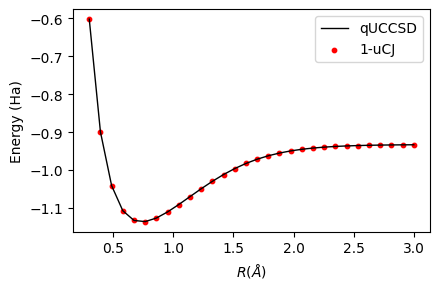

In [202]:
plt.figure(figsize=(4.5,3))
plt.plot(Rs, E_ccsd, label="qUCCSD", linewidth=1, c='k')
plt.scatter(Rs, E_k1, label="1-uCJ", c = 'r', s=10)
plt.xlabel(r"$R (Å)$")
plt.ylabel(r"Energy (Ha)")
plt.legend()
plt.tight_layout()

tikzplotlib.save("figures/energy_curves.tex",axis_width="0.8\\linewidth",   axis_height="0.6\\linewidth")

In [203]:
print(f"Equilibrium bond-length qUCCSD: {Rs[np.argmin(E_ccsd)]} Å", 
      f"\nEquilibrium bond-length 1-uCJ:  {Rs[np.argmin(E_k1)]} Å")

Equilibrium bond-length qUCCSD: 0.7655172413793103 Å 
Equilibrium bond-length 1-uCJ:  0.7655172413793103 Å


We observe identical equilibrium bond lengths for both methods. 

Now, why do we care? Let's look at the circuit depths.

In [204]:
mol = pyscf.gto.Mole()
mol.atom = "H 0 0 0; H 0 0 0.741"
mol.basis = "sto-3g"
mol.unit = "Angstrom"
mol.verbose = 0
mol.build()

rhf = pyscf.scf.RHF(mol).run()
ccsd = pyscf.cc.CCSD(rhf).run()

# build the UCJ/LUCJ circuit
def build_ucj_qc(rhf, ccsd, n_reps=1):
    mo_occ = np.asarray(rhf.mo_occ)                  # 0 or 2 per spatial MO
    norb_tot = rhf.mo_coeff.shape[1]
    active = list(range(norb_tot))
    norb = len(active)
    n_elec_act = int(round(mo_occ[active].sum()))
    nelec = (n_elec_act // 2, n_elec_act // 2)

    # LUCJ locality: same-spin nearest-neighbor opposite-spin on-site
    pairs_aa = [(p, p+1) for p in range(norb-1)]
    pairs_ab = [(p, p)   for p in range(norb)]
    int_pairs = (pairs_aa, pairs_ab)

    ucj_lucj = ffsim.UCJOpSpinBalanced.from_t_amplitudes(ccsd.t2, t1=ccsd.t1, 
                                                        n_reps=n_reps,interaction_pairs=int_pairs)

    qr = QuantumRegister(2 * norb)
    qc = QuantumCircuit(qr)
    qc.append(ffsim.qiskit.PrepareHartreeFockJW(norb, nelec), qr)
    qc.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_lucj), qr)
    return qc, norb, nelec, int_pairs

#  Build 1-uCJ circuit
qc, norb, nelec, int_pairs = build_ucj_qc(rhf, ccsd, n_reps=1)

n_qubits = qc.num_qubits
num_spatial_orbitals = n_qubits // 2
num_particles = nelec                            

mapper = JordanWignerMapper()
hf_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
uccsd = UCCSD(num_spatial_orbitals=num_spatial_orbitals,num_particles=num_particles,
    qubit_mapper=mapper,initial_state=hf_state,reps=1, generalized=False,)

print("qUCCSD parameter count:", len(uccsd.parameters))

backend = GenericBackendV2(n_qubits, basis_gates=["rz","sx","x","cx"])
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
pm.pre_init = getattr(ffsim.qiskit, "PRE_INIT", None)

def summarize(label, circ):
    tc = pm.run(circ.decompose())
    print(f"{label} ops:", tc.count_ops(), " depth:", tc.depth())
    return tc

tqc_ucj   = summarize("1-uCJ", qc)
tqc_uccsd = summarize("qUCCSD", uccsd)

qUCCSD parameter count: 3
1-uCJ ops: OrderedDict({'rz': 36, 'sx': 20, 'cx': 14, 'x': 2})  depth: 25
qUCCSD ops: OrderedDict({'rz': 90, 'sx': 57, 'cx': 49, 'x': 1})  depth: 124


So, the depth of the qUCCSD is 5 times larger than a single uCJ!

## **1-uCJ circuit**

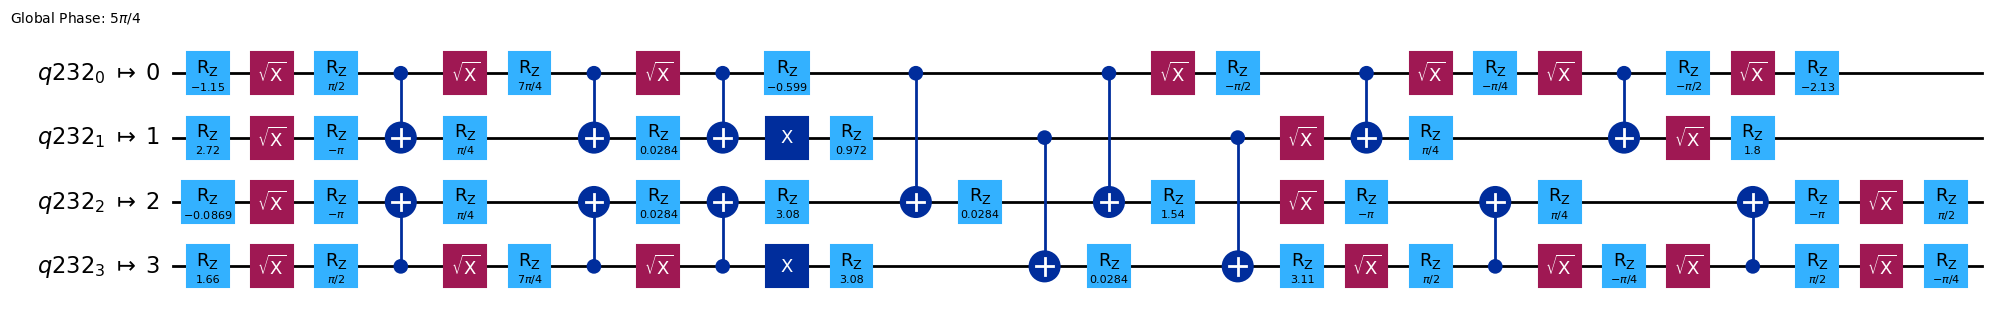

In [205]:
tqc_ucj.draw("mpl", fold=-1)

## **UCCSD circuit**

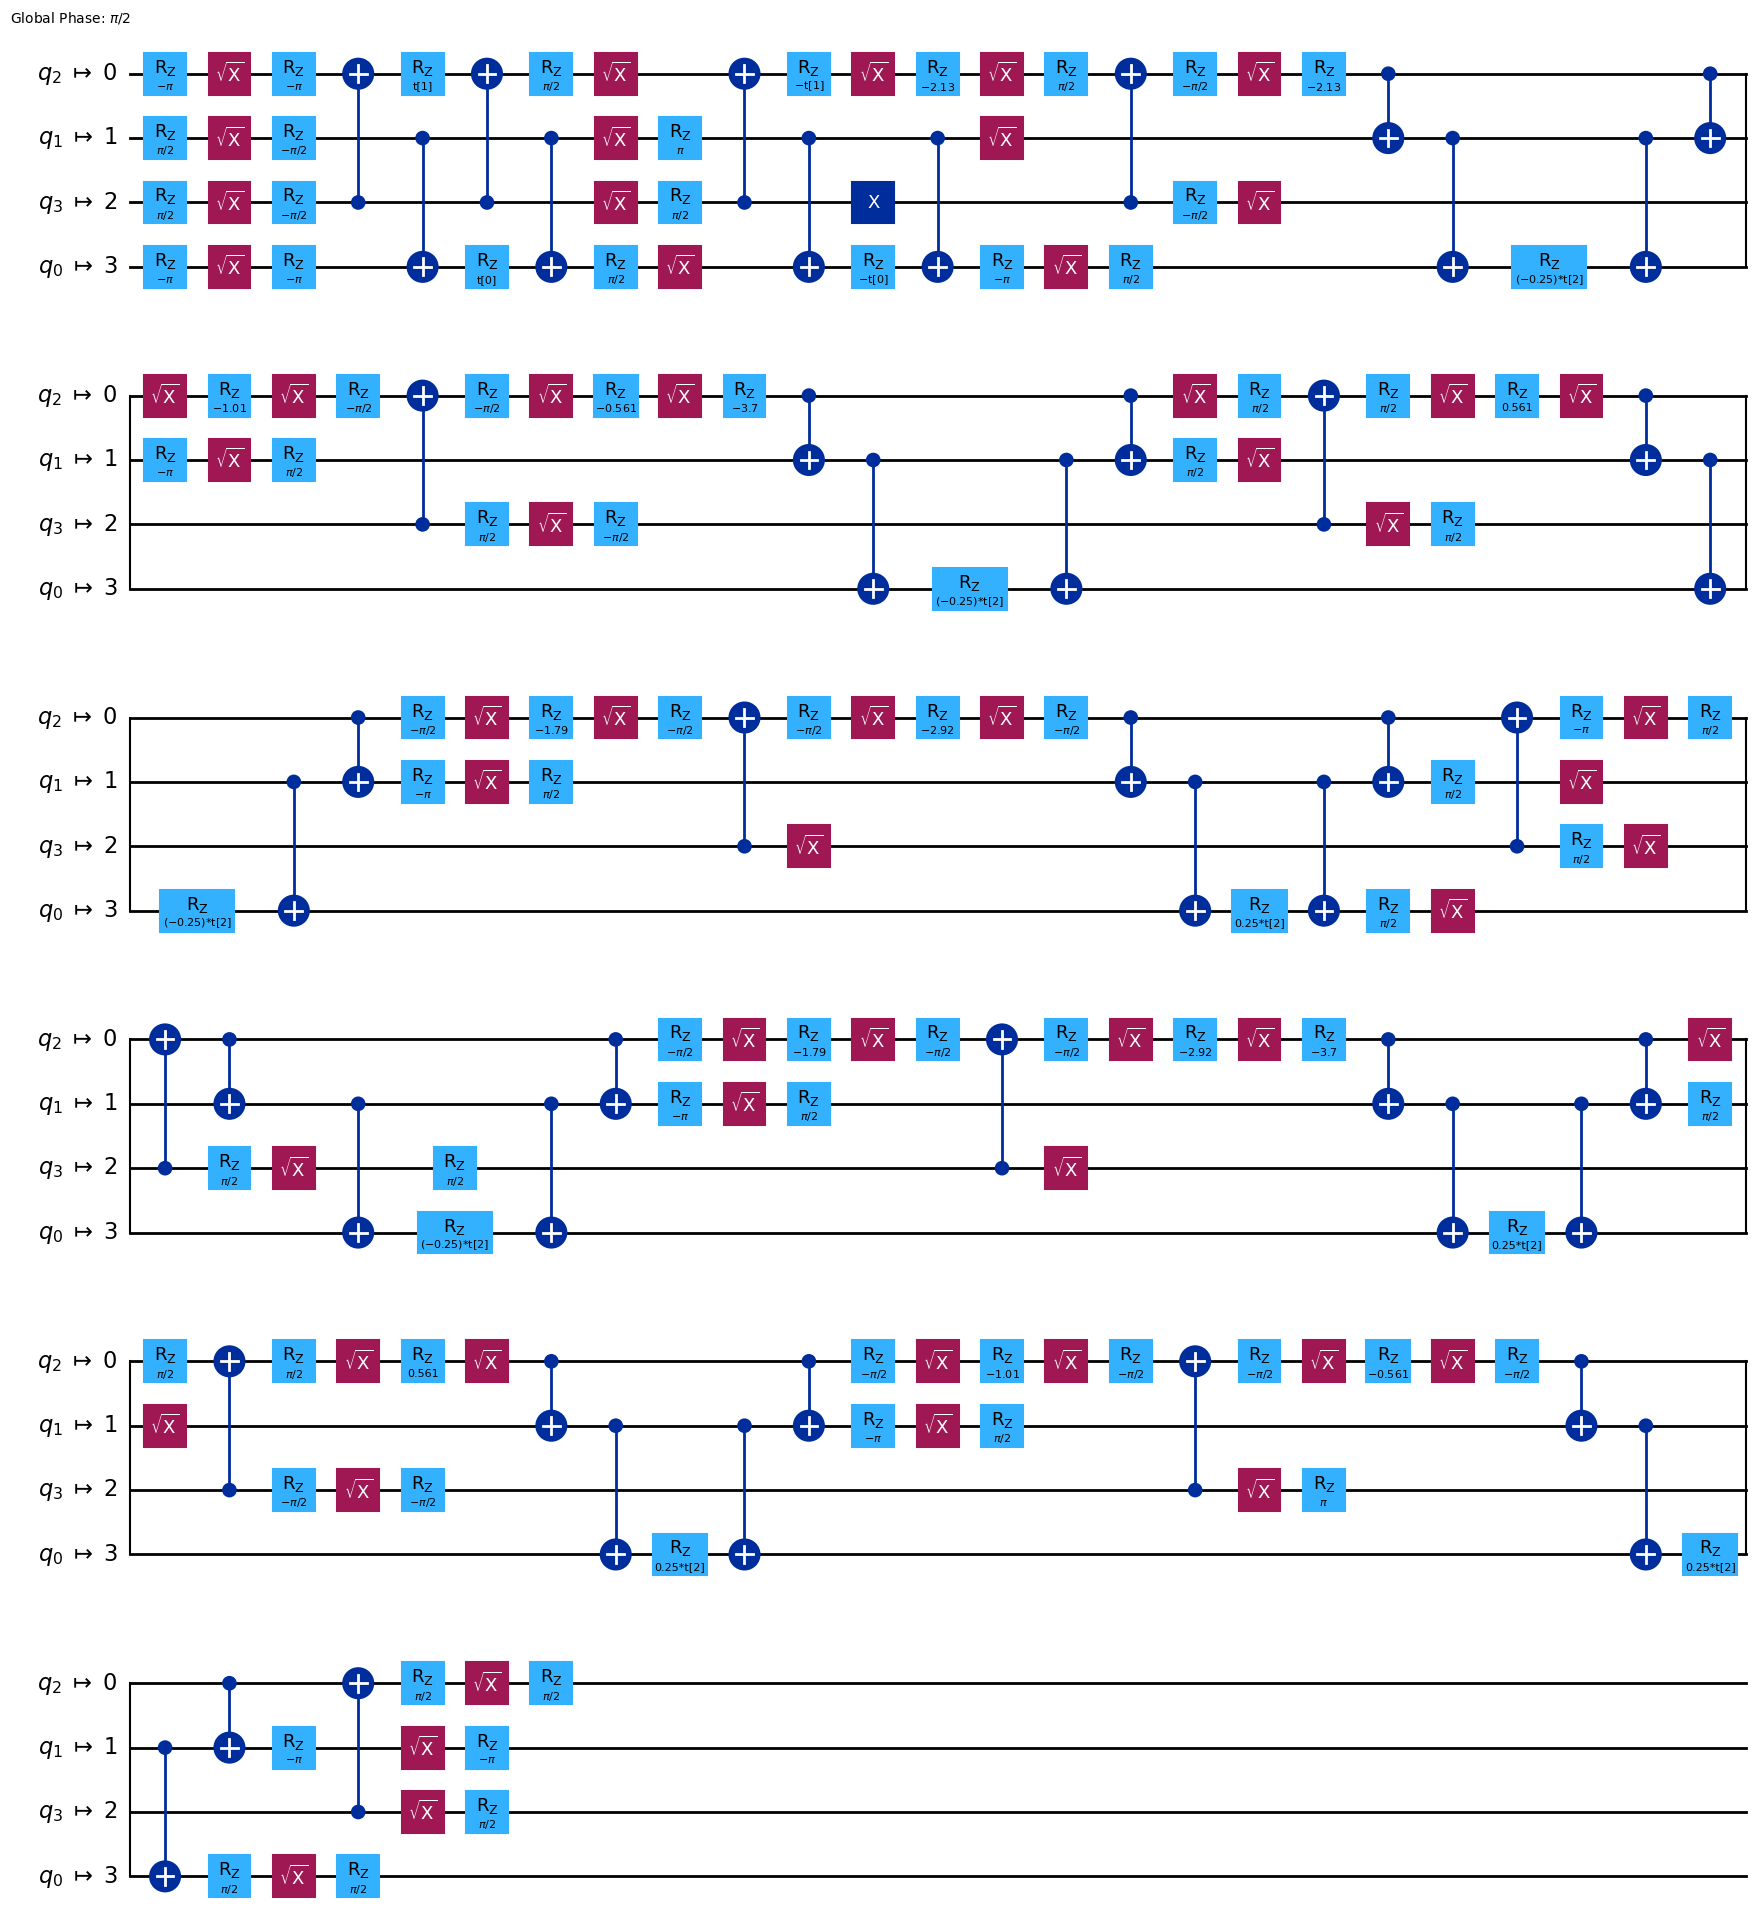

In [206]:
tqc_uccsd.draw("mpl")